# Waymo Open Dataset Motion Tutorial

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset

This tutorial demonstrates:
- How to decode and interpret the data.
- How to train a simple model with Tensorflow.

Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

To use, open this notebook in [Colab](https://colab.research.google.com).

Uncheck the box "Reset all runtimes before running" if you run this colab directly from the remote kernel. Alternatively, you can make a copy before trying to run it by following "File > Save copy in Drive ...".

# Package installation

Please follow the instructions in [tutorial.ipynb](https://github.com/waymo-research/waymo-open-dataset/blob/master/tutorial/tutorial.ipynb).

# Imports and global definitions

In [20]:
# Data location. Please edit.

# A tfrecord containing tf.Example protos as downloaded from the Waymo dataset
# webpage.

# Replace this path with your own tfrecords.
FILENAME = './data_processing/data/training_tfexample.tfrecord-00009-of-01000'

In [21]:
import math
import os
import uuid
import time

from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.pyplot as plt

import numpy as np
from IPython.display import HTML
import itertools
import tensorflow as tf
import pandas as pd

from google.protobuf import text_format
from waymo_open_dataset.metrics.ops import py_metrics_ops
from waymo_open_dataset.metrics.python import config_util_py as config_util
from waymo_open_dataset.protos import motion_metrics_pb2

# Example field definition
roadgraph_features = {
    'roadgraph_samples/dir':
        tf.io.FixedLenFeature([20000, 3], tf.float32, default_value=None),
    'roadgraph_samples/id':
        tf.io.FixedLenFeature([20000, 1], tf.int64, default_value=None),
    'roadgraph_samples/type':
        tf.io.FixedLenFeature([20000, 1], tf.int64, default_value=None),
    'roadgraph_samples/valid':
        tf.io.FixedLenFeature([20000, 1], tf.int64, default_value=None),
    'roadgraph_samples/xyz':
        tf.io.FixedLenFeature([20000, 3], tf.float32, default_value=None),
}

# Features of other agents.
state_features = {
    'state/id':
        tf.io.FixedLenFeature([128], tf.float32, default_value=None),
    'state/type':
        tf.io.FixedLenFeature([128], tf.float32, default_value=None),
    'state/is_sdc':
        tf.io.FixedLenFeature([128], tf.int64, default_value=None),
    'state/tracks_to_predict':
        tf.io.FixedLenFeature([128], tf.int64, default_value=None),
    'state/current/bbox_yaw':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/height':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/length':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/timestamp_micros':
        tf.io.FixedLenFeature([128, 1], tf.int64, default_value=None),
    'state/current/valid':
        tf.io.FixedLenFeature([128, 1], tf.int64, default_value=None),
    'state/current/vel_yaw':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/velocity_x':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/velocity_y':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/width':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/x':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/y':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/current/z':
        tf.io.FixedLenFeature([128, 1], tf.float32, default_value=None),
    'state/future/bbox_yaw':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/height':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/length':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/timestamp_micros':
        tf.io.FixedLenFeature([128, 80], tf.int64, default_value=None),
    'state/future/valid':
        tf.io.FixedLenFeature([128, 80], tf.int64, default_value=None),
    'state/future/vel_yaw':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/velocity_x':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/velocity_y':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/width':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/x':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/y':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/future/z':
        tf.io.FixedLenFeature([128, 80], tf.float32, default_value=None),
    'state/past/bbox_yaw':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/height':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/length':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/timestamp_micros':
        tf.io.FixedLenFeature([128, 10], tf.int64, default_value=None),
    'state/past/valid':
        tf.io.FixedLenFeature([128, 10], tf.int64, default_value=None),
    'state/past/vel_yaw':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/velocity_x':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/velocity_y':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/width':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/x':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/y':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
    'state/past/z':
        tf.io.FixedLenFeature([128, 10], tf.float32, default_value=None),
}

traffic_light_features = {
    'traffic_light_state/current/state':
        tf.io.FixedLenFeature([1, 16], tf.int64, default_value=None),
    'traffic_light_state/current/valid':
        tf.io.FixedLenFeature([1, 16], tf.int64, default_value=None),
    'traffic_light_state/current/x':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/current/y':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/current/z':
        tf.io.FixedLenFeature([1, 16], tf.float32, default_value=None),
    'traffic_light_state/past/state':
        tf.io.FixedLenFeature([10, 16], tf.int64, default_value=None),
    'traffic_light_state/past/valid':
        tf.io.FixedLenFeature([10, 16], tf.int64, default_value=None),
    'traffic_light_state/past/x':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
    'traffic_light_state/past/y':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
    'traffic_light_state/past/z':
        tf.io.FixedLenFeature([10, 16], tf.float32, default_value=None),
}

scenario_features = {
    'scenario/id':
        tf.io.FixedLenFeature([1], tf.string, default_value = None)
}

features_description = {}
features_description.update(roadgraph_features)
features_description.update(state_features)
features_description.update(traffic_light_features)
features_description.update(scenario_features)

# Visualize TF Example sample

## Create Dataset.

In [3]:
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
data = next(dataset.as_numpy_iterator())
print(type(data))
parsed = tf.io.parse_single_example(data, features_description)

<class 'bytes'>


## Generate visualization images.

In [5]:
def create_figure_and_axes(size_pixels):
  """Initializes a unique figure and axes for plotting."""
  fig, ax = plt.subplots(1, 1, num=uuid.uuid4())

  # Sets output image to pixel resolution.
  dpi = 100
  size_inches = size_pixels / dpi
  fig.set_size_inches([size_inches, size_inches])
  fig.set_dpi(dpi)
  fig.set_facecolor('white')
  ax.set_facecolor('white')
  ax.xaxis.label.set_color('black')
  ax.tick_params(axis='x', colors='black')
  ax.yaxis.label.set_color('black')
  ax.tick_params(axis='y', colors='black')
  fig.set_tight_layout(True)
  ax.grid(False)
  return fig, ax


def fig_canvas_image(fig):
  """Returns a [H, W, 3] uint8 np.array image from fig.canvas.tostring_rgb()."""
  # Just enough margin in the figure to display xticks and yticks.
  fig.subplots_adjust(
      left=0.08, bottom=0.08, right=0.98, top=0.98, wspace=0.0, hspace=0.0)
  fig.canvas.draw()
  data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  return data.reshape(fig.canvas.get_width_height()[::-1] + (3,))


def get_colormap(num_agents):
  """Compute a color map array of shape [num_agents, 4]."""
  colors = cm.get_cmap('jet', num_agents)
  colors = colors(range(num_agents))
  np.random.shuffle(colors)
  return colors


def get_viewport(all_states, all_states_mask):
  """Gets the region containing the data.

  Args:
    all_states: states of agents as an array of shape [num_agents, num_steps,
      2].
    all_states_mask: binary mask of shape [num_agents, num_steps] for
      `all_states`.

  Returns:
    center_y: float. y coordinate for center of data.
    center_x: float. x coordinate for center of data.
    width: float. Width of data.
  """
  valid_states = all_states[all_states_mask]
  all_y = valid_states[..., 1]
  all_x = valid_states[..., 0]

  center_y = (np.max(all_y) + np.min(all_y)) / 2
  center_x = (np.max(all_x) + np.min(all_x)) / 2

  range_y = np.ptp(all_y)
  range_x = np.ptp(all_x)

  width = max(range_y, range_x)

  return center_y, center_x, width


def visualize_one_step(states,
                       mask,
                       roadgraph,
                       roadgraph_id,
                       title,
                       center_y,
                       center_x,
                       width,
                       color_map,
                       size_pixels=1000):
  """Generate visualization for a single step."""

  # Create figure and axes.
  fig, ax = create_figure_and_axes(size_pixels=size_pixels)

  # Plot roadgraph.
  rg_pts = roadgraph[:, :2].T
  ax.plot(rg_pts[0, :], rg_pts[1, :], 'k.', alpha=1, ms=2)

  masked_x = states[:, 0][mask]
  masked_y = states[:, 1][mask]
  colors = color_map[mask]

  # Plot agent current position.
  ax.scatter(
      masked_x,
      masked_y,
      marker='o',
      linewidths=3,
      color=colors,
  )

  # Title.
  ax.set_title(title)

  # Set axes.  Should be at least 10m on a side and cover 160% of agents.
  size = max(10, width * 1.0)
  ax.axis([
      -size / 2 + center_x, size / 2 + center_x, -size / 2 + center_y,
      size / 2 + center_y
  ])
  ax.set_aspect('equal')

  image = fig_canvas_image(fig)
  plt.close(fig)
  return image


def visualize_all_agents_smooth(
    decoded_example,
    size_pixels=1000,
):
  """Visualizes all agent predicted trajectories in a serie of images.

  Args:
    decoded_example: Dictionary containing agent info about all modeled agents.
    size_pixels: The size in pixels of the output image.

  Returns:
    T of [H, W, 3] uint8 np.arrays of the drawn matplotlib's figure canvas.
  """
  # [num_agents, num_past_steps, 2] float32.
  past_states = tf.stack(
      [decoded_example['state/past/x'], decoded_example['state/past/y']],
      -1).numpy()
  past_states_mask = decoded_example['state/past/valid'].numpy() > 0.0

  # [num_agents, 1, 2] float32.
  current_states = tf.stack(
      [decoded_example['state/current/x'], decoded_example['state/current/y']],
      -1).numpy()
  current_states_mask = decoded_example['state/current/valid'].numpy() > 0.0

  # [num_agents, num_future_steps, 2] float32.
  future_states = tf.stack(
      [decoded_example['state/future/x'], decoded_example['state/future/y']],
      -1).numpy()
  future_states_mask = decoded_example['state/future/valid'].numpy() > 0.0

  # [num_points, 3] float32.
  roadgraph_xyz = decoded_example['roadgraph_samples/xyz'].numpy()

  # [num_points, 1]
  roadgraph_id = decoded_example['roadgraph_samples/id'].numpy()
    
  num_agents, num_past_steps, _ = past_states.shape
  num_future_steps = future_states.shape[1]

  color_map = get_colormap(num_agents)

  # [num_agens, num_past_steps + 1 + num_future_steps, depth] float32.
  all_states = np.concatenate([past_states, current_states, future_states], 1)

  # [num_agens, num_past_steps + 1 + num_future_steps] float32.
  all_states_mask = np.concatenate(
      [past_states_mask, current_states_mask, future_states_mask], 1)

  center_y, center_x, width = get_viewport(all_states, all_states_mask)

  images = []

  # Generate images from past time steps.
  for i, (s, m) in enumerate(
      zip(
          np.split(past_states, num_past_steps, 1),
          np.split(past_states_mask, num_past_steps, 1))):
    im = visualize_one_step(s[:, 0], m[:, 0], roadgraph_xyz, roadgraph_id,
                            'past: %d' % (num_past_steps - i), center_y,
                            center_x, width, color_map, size_pixels)
    images.append(im)

  # Generate one image for the current time step.
  s = current_states
  m = current_states_mask

  im = visualize_one_step(s[:, 0], m[:, 0], roadgraph_xyz, roadgraph_id, 'current', center_y,
                          center_x, width, color_map, size_pixels)
  images.append(im)

  # Generate images from future time steps.
  for i, (s, m) in enumerate(
      zip(
          np.split(future_states, num_future_steps, 1),
          np.split(future_states_mask, num_future_steps, 1))):
    im = visualize_one_step(s[:, 0], m[:, 0], roadgraph_xyz, roadgraph_id,
                            'future: %d' % (i + 1), center_y, center_x, width,
                            color_map, size_pixels)
    images.append(im)

  return images


images = visualize_all_agents_smooth(parsed)

## Display animation.

In [7]:
def create_animation(images):
  """ Creates a Matplotlib animation of the given images.

  Args:
    images: A list of numpy arrays representing the images.

  Returns:
    A matplotlib.animation.Animation.

  Usage:
    anim = create_animation(images)
    anim.save('/tmp/animation.avi')
    HTML(anim.to_html5_video())
  """

  plt.ioff()
  fig, ax = plt.subplots()
  dpi = 100
  size_inches = 1000 / dpi
  fig.set_size_inches([size_inches, size_inches])
  plt.ion()

  def animate_func(i):
    ax.imshow(images[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid('off')

  anim = animation.FuncAnimation(
      fig, animate_func, frames=len(images) // 2, interval=100)
  plt.close(fig)
  return anim


anim = create_animation(images[::5])
HTML(anim.to_html5_video())

## Visualize Roadgraph

In [10]:
def visualize_one_step(states,
                       mask,
                       roadgraph,
                       roadgraph_id,
                       title,
                       center_y,
                       center_x,
                       width,
                       color_map,
                       start,
                       end,
                       size_pixels=1000):
  """Generate visualization for a single step."""

  # Create figure and axes.
  fig, ax = create_figure_and_axes(size_pixels=size_pixels)

  # Plot roadgraph.
  rg_pts = roadgraph[:, :2].T
#   ax.plot(rg_pts[0, :], rg_pts[1, :], 'k.', alpha=1, ms=2)
    
  # 'roadgraph_samples/id'
  roadgraph_data = pd.DataFrame({'x': rg_pts[0, :], 'y': rg_pts[1, :], 'category': roadgraph_id[:, 0]})

  groups = roadgraph_data.groupby('category')
  for cat, group in groups:
    if start <= cat < end:
        ax.plot(group['x'], group['y'], '.', alpha=1, ms=3, label=cat)
  ax.legend(fontsize='large')

  # Title.
  ax.set_title(title)

  # Set axes.  Should be at least 10m on a side and cover 160% of agents.
  size = max(10, width * 1.0)
  ax.axis([
      -size / 2 + center_x, size / 2 + center_x, -size / 2 + center_y,
      size / 2 + center_y
  ])
  ax.set_aspect('equal')

  image = fig_canvas_image(fig)
  plt.close(fig)
  return image


decoded_example = tf.io.parse_single_example(data, features_description)

# [num_agents, num_past_steps, 2] float32.
past_states = tf.stack(
  [decoded_example['state/past/x'], decoded_example['state/past/y']],
  -1).numpy()
past_states_mask = decoded_example['state/past/valid'].numpy() > 0.0

# [num_agents, 1, 2] float32.
current_states = tf.stack(
  [decoded_example['state/current/x'], decoded_example['state/current/y']],
  -1).numpy()
current_states_mask = decoded_example['state/current/valid'].numpy() > 0.0

# [num_agents, num_future_steps, 2] float32.
future_states = tf.stack(
  [decoded_example['state/future/x'], decoded_example['state/future/y']],
  -1).numpy()
future_states_mask = decoded_example['state/future/valid'].numpy() > 0.0

# [num_points, 3] float32.
roadgraph_xyz = decoded_example['roadgraph_samples/xyz'].numpy()

# [num_points, 1]
roadgraph_id = decoded_example['roadgraph_samples/id'].numpy()

num_agents, num_past_steps, _ = past_states.shape
num_future_steps = future_states.shape[1]

color_map = get_colormap(num_agents)

# [num_agens, num_past_steps + 1 + num_future_steps, depth] float32.
all_states = np.concatenate([past_states, current_states, future_states], 1)

# [num_agens, num_past_steps + 1 + num_future_steps] float32.
all_states_mask = np.concatenate(
  [past_states_mask, current_states_mask, future_states_mask], 1)

center_y, center_x, width = get_viewport(all_states, all_states_mask)


# Generate one image for the current time step.
s = current_states
m = current_states_mask
size_pixels=1000

def plot_im(image):
    plt.ioff()
    fig, ax = plt.subplots()
    dpi = 100
    size_inches = 1000 / dpi
    fig.set_size_inches([size_inches, size_inches])
    plt.ion()

    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid('off')
    
map_pos = decoded_example['roadgraph_samples/xyz'].numpy()
map_pos_max = map_pos.max(0)
map_pos_min = map_pos.min(0)
map_center_x = (map_pos_max[0] + map_pos_min[0]) / 2
map_center_y = (map_pos_max[1] + map_pos_min[1]) / 2
map_width = np.max([map_pos_max[0]-map_pos_min[0], map_pos_max[1]-map_pos_min[1]])
print(map_width)

229.40723


<ipython-input-5-29b290fee937>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 1, num=uuid.uuid4())
<ipython-input-10-f1c9828d2209>:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


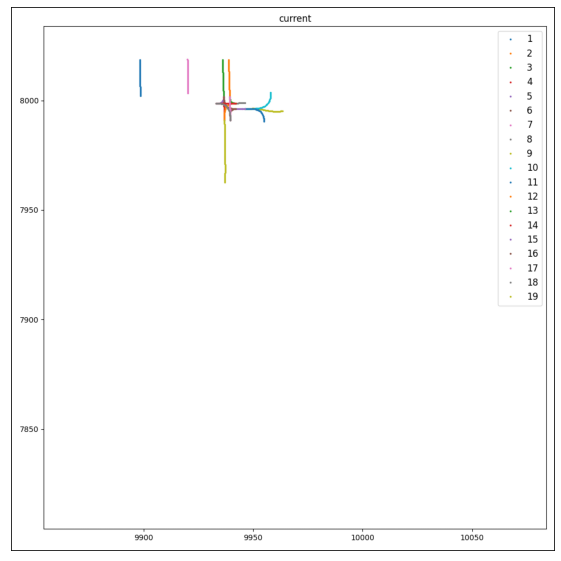

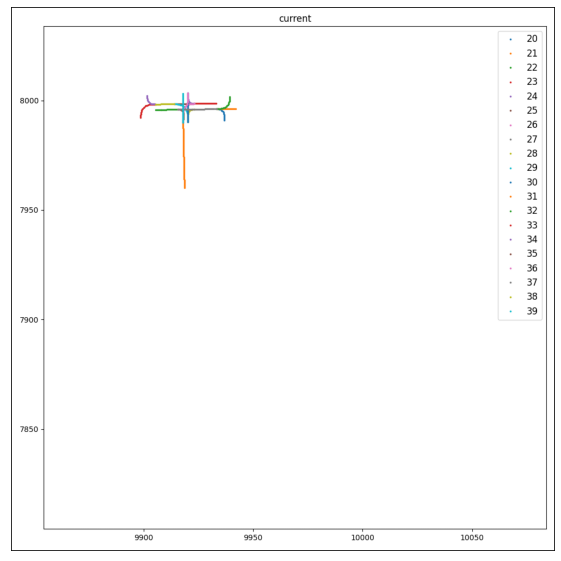

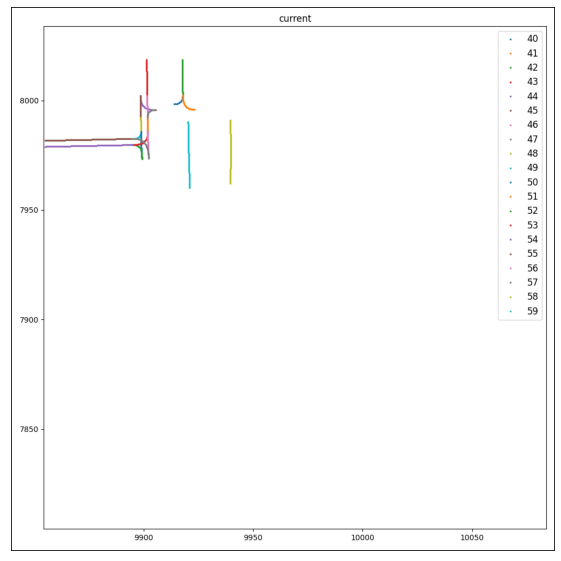

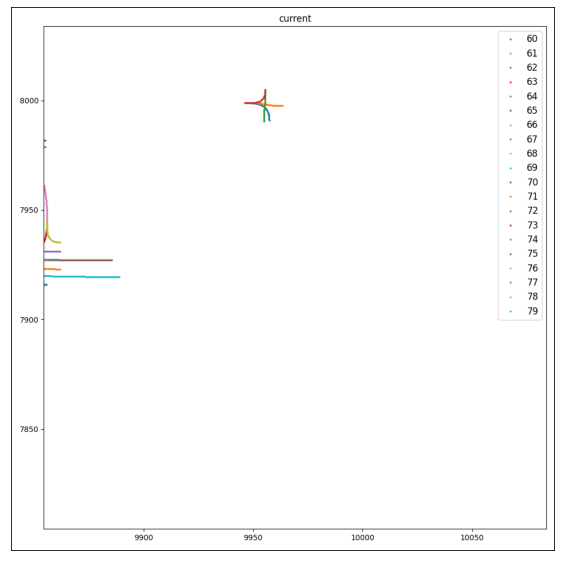

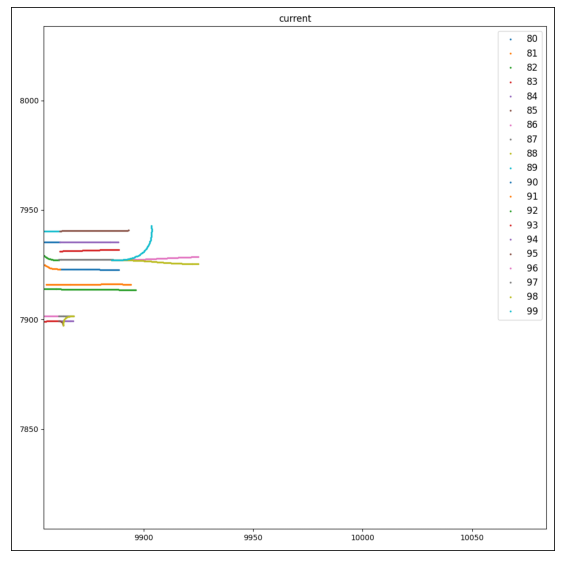

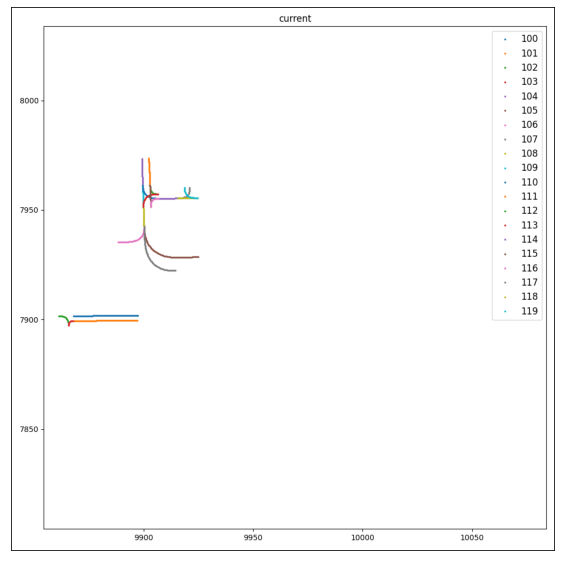

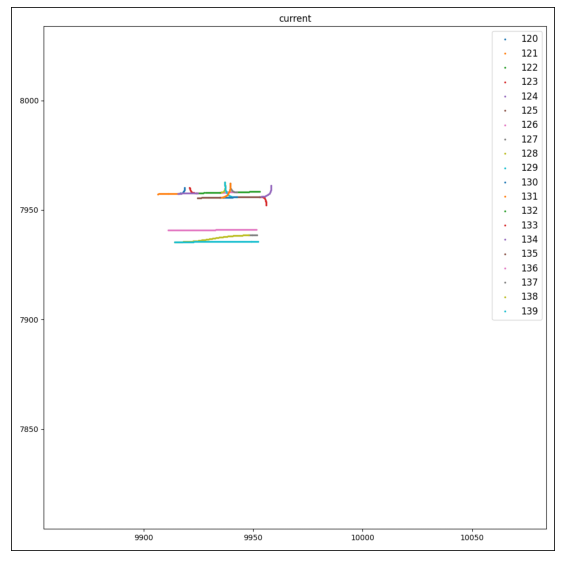

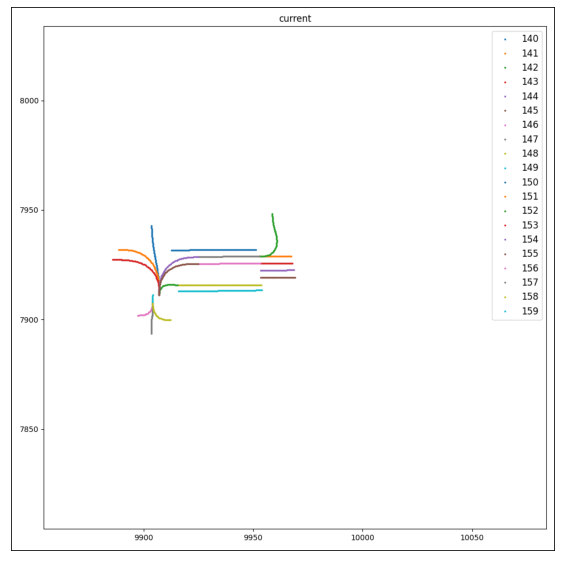

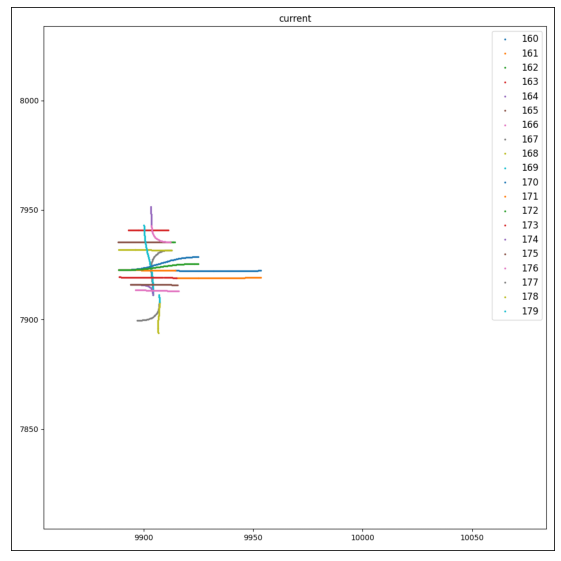

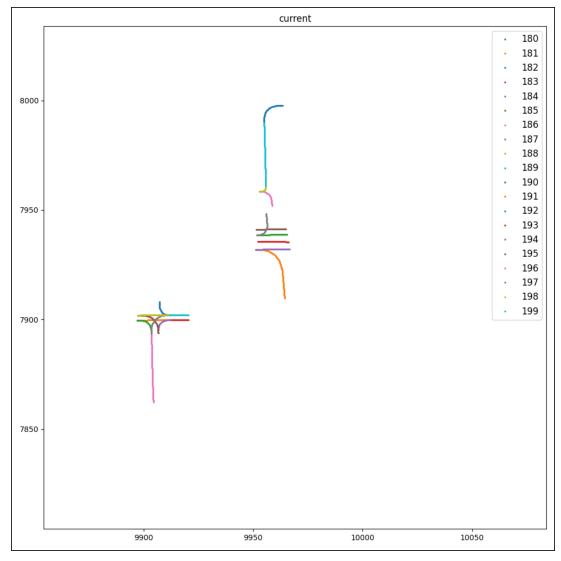

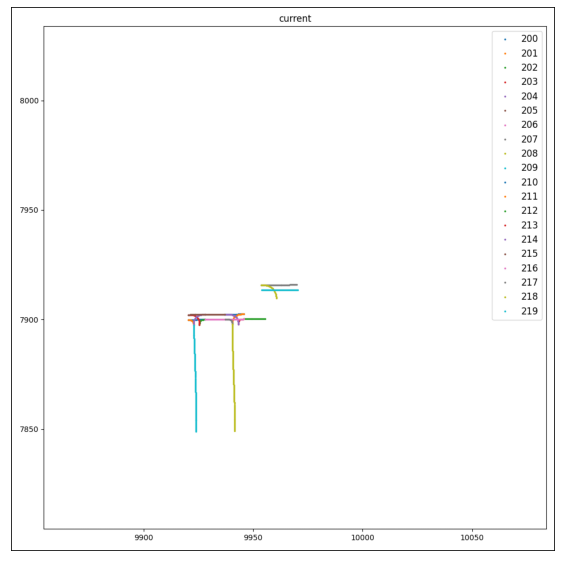

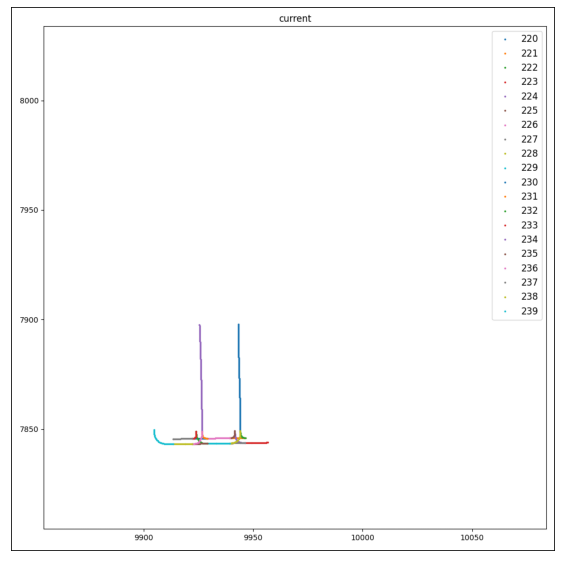

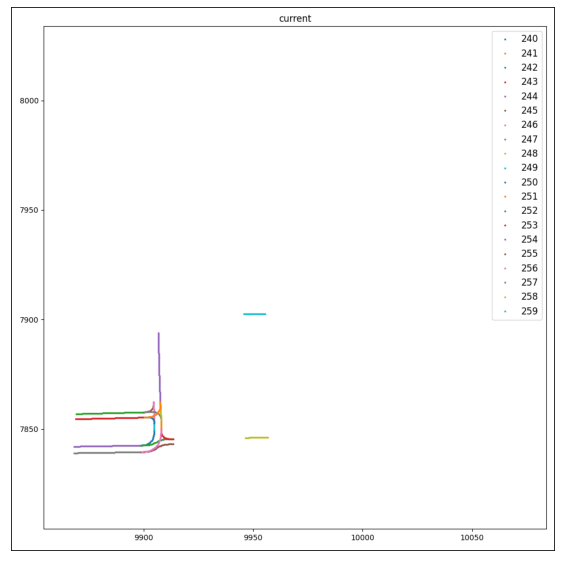

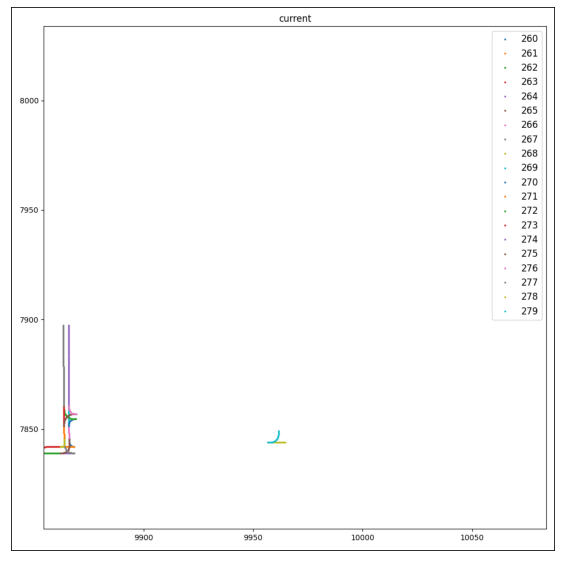

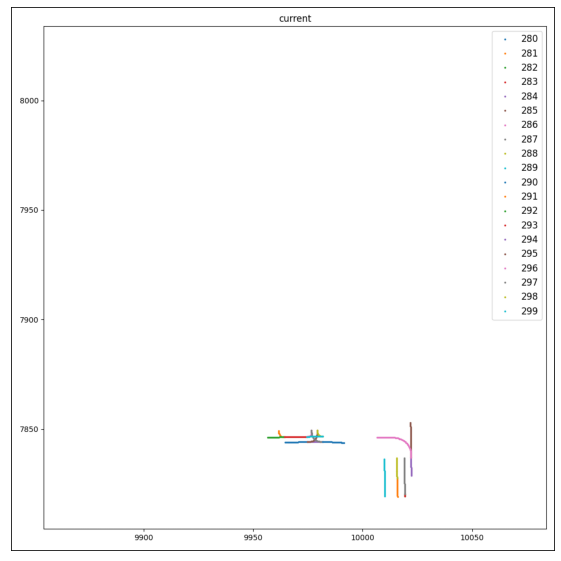

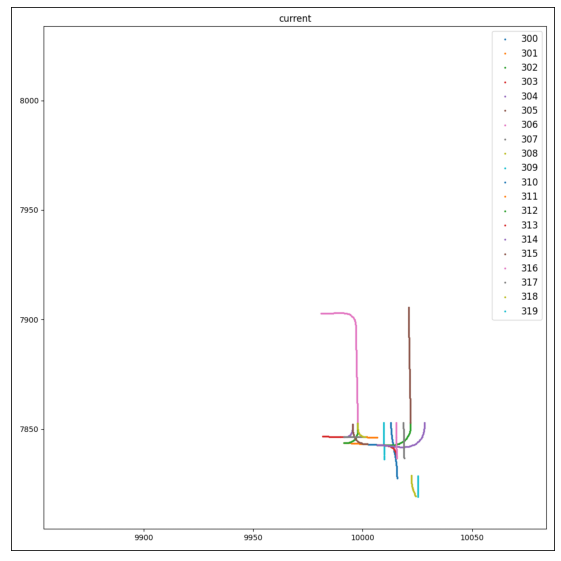

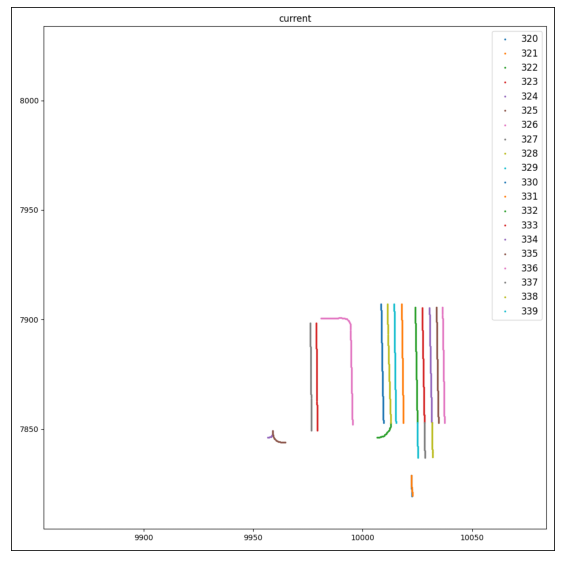

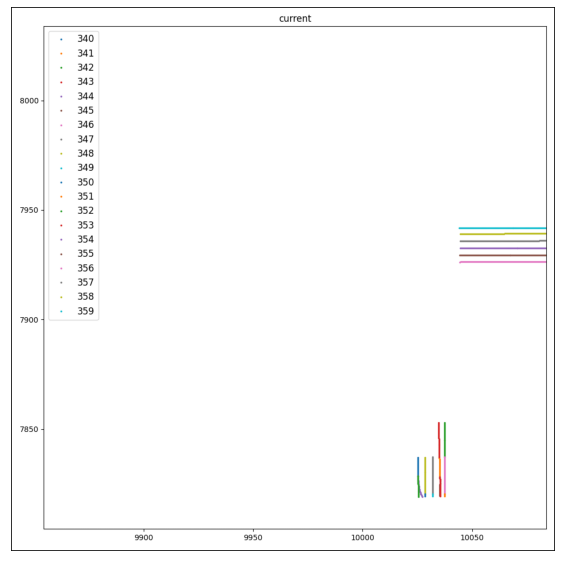

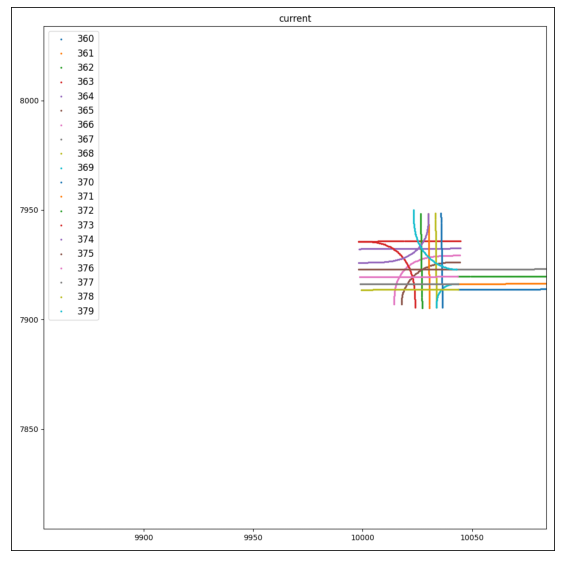

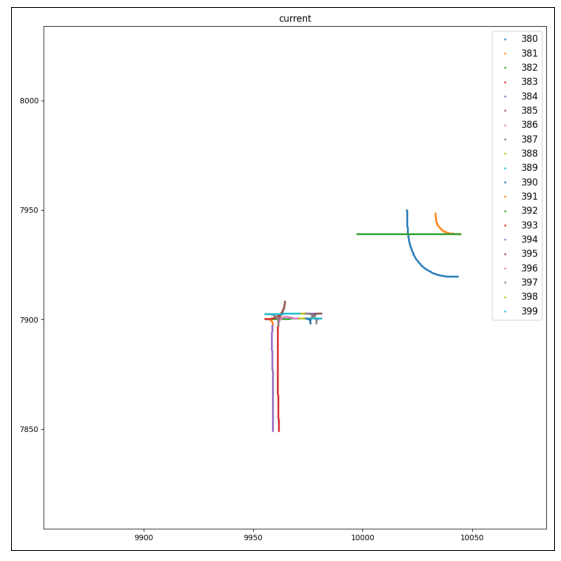

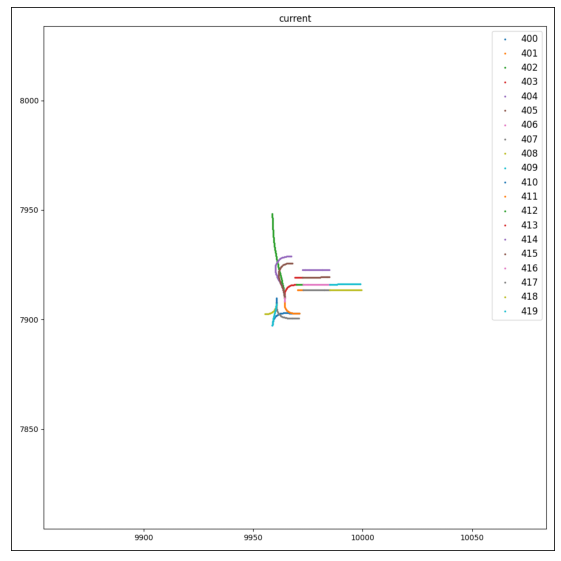

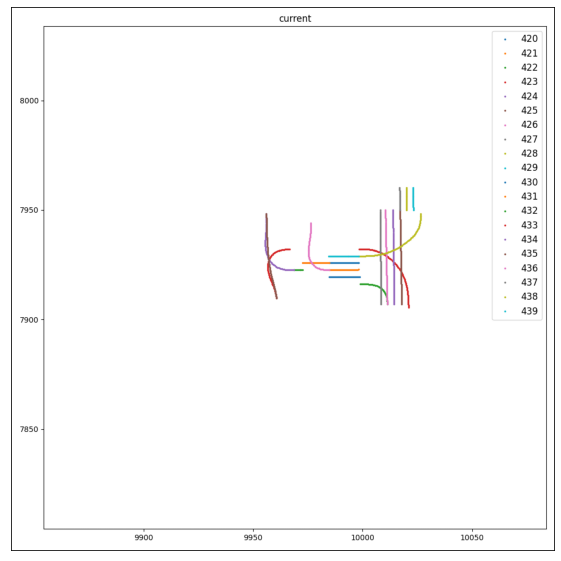

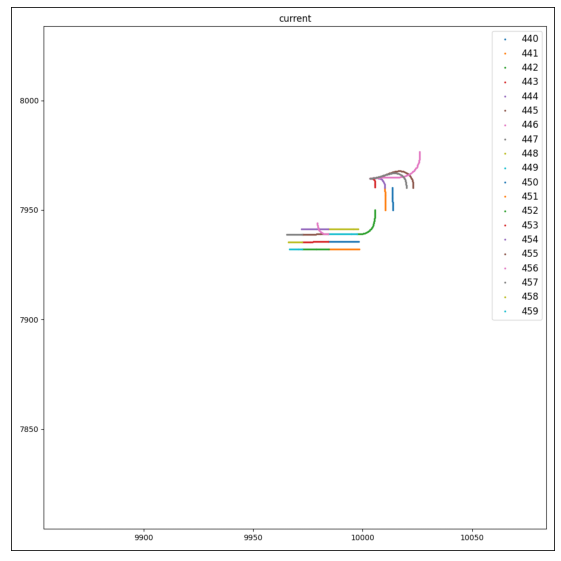

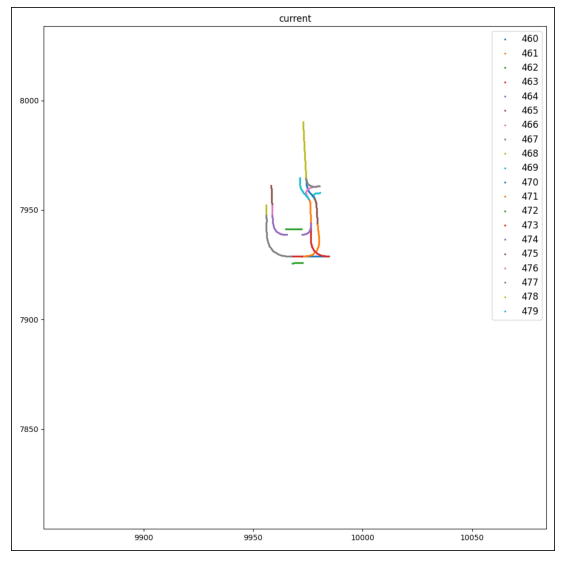

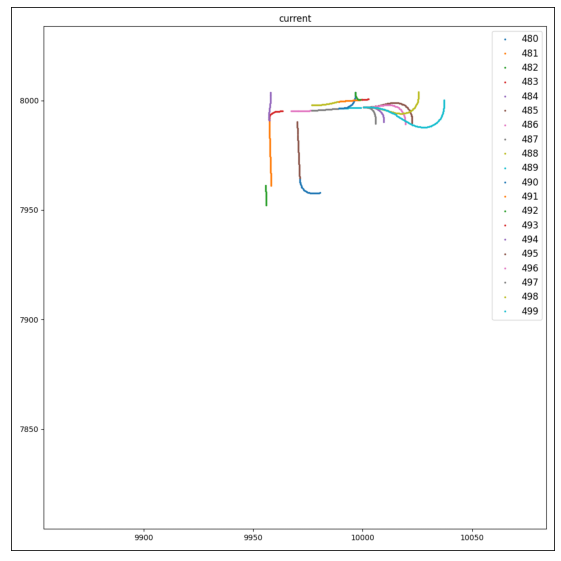

In [11]:
for start in range(0, 500, 20):
    image = visualize_one_step(s[:, 0], m[:, 0], roadgraph_xyz, roadgraph_id, 'current', map_center_y,
                          map_center_x, map_width, color_map, start, start+20, size_pixels)
    plot_im(image)

# Details of tf.Example format

In [12]:
decoded_example = tf.io.parse_single_example(data, features_description)

In [27]:
print('the id', decoded_example['scenario/id'])

the id tf.Tensor([b'7bf4f2ce60321112'], shape=(1,), dtype=string)


In [51]:
# roadgraph_samples/id
print('the id of the map data point: ', decoded_example['roadgraph_samples/id'])
a = decoded_example['roadgraph_samples/id']
count = []
for i in range(1, 573):
    count.append(np.count_nonzero(a == i))
print(count)

the id of the map data point:  tf.Tensor(
[[  1]
 [  1]
 [  1]
 ...
 [572]
 [572]
 [572]], shape=(20000, 1), dtype=int64)
[34, 35, 35, 23, 12, 20, 32, 10, 36, 34, 26, 23, 11, 19, 10, 16, 23, 25, 58, 16, 19, 21, 21, 15, 20, 25, 21, 17, 26, 28, 61, 22, 23, 14, 17, 22, 17, 18, 28, 16, 22, 32, 34, 23, 21, 22, 14, 14, 14, 27, 14, 20, 23, 81, 81, 27, 29, 59, 61, 33, 37, 32, 27, 2, 2, 35, 3, 20, 15, 3, 16, 14, 19, 15, 51, 14, 14, 28, 56, 55, 79, 85, 14, 15, 8, 14, 15, 16, 16, 15, 16, 15, 55, 55, 64, 80, 52, 81, 58, 60, 60, 16, 8, 26, 69, 35, 60, 18, 21, 23, 27, 14, 22, 20, 21, 14, 18, 19, 19, 11, 20, 22, 13, 19, 22, 17, 13, 14, 22, 17, 20, 21, 12, 20, 22, 82, 9, 69, 78, 79, 31, 51, 31, 32, 33, 58, 57, 78, 78, 65, 66, 24, 64, 59, 55, 23, 31, 28, 8, 80, 79, 6, 38, 19, 49, 28, 55, 50, 66, 75, 53, 75, 53, 27, 44, 41, 32, 31, 8, 20, 61, 29, 29, 32, 28, 21, 27, 11, 60, 28, 31, 22, 18, 20, 30, 65, 30, 31, 18, 17, 10, 10, 18, 18, 17, 20, 34, 22, 34, 19, 18, 21, 9, 19, 20, 18, 11, 99, 99, 99, 16, 11, 

In [45]:
print(decoded_example['roadgraph_samples/xyz'][0:100])

tf.Tensor(
[[9898.255    8018.4634    -72.05614 ]
 [9898.263    8017.966     -72.054504]
 [9898.2705   8017.468     -72.05287 ]
 [9898.279    8016.97      -72.05124 ]
 [9898.287    8016.472     -72.04961 ]
 [9898.295    8015.9746    -72.04797 ]
 [9898.303    8015.4766    -72.04634 ]
 [9898.312    8014.979     -72.04471 ]
 [9898.319    8014.481     -72.043076]
 [9898.327    8013.983     -72.04144 ]
 [9898.335    8013.4854    -72.03981 ]
 [9898.344    8012.9873    -72.03818 ]
 [9898.352    8012.4897    -72.036545]
 [9898.359    8011.9917    -72.03491 ]
 [9898.367    8011.494     -72.03328 ]
 [9898.376    8010.996     -72.03165 ]
 [9898.384    8010.4985    -72.030014]
 [9898.392    8010.0005    -72.02838 ]
 [9898.4      8009.503     -72.02675 ]
 [9898.408    8009.005     -72.025116]
 [9898.416    8008.5073    -72.02348 ]
 [9898.424    8008.0093    -72.02185 ]
 [9898.433    8007.511     -72.02022 ]
 [9898.44     8007.0137    -72.018585]
 [9898.448    8006.5156    -72.01695 ]
 [9898.456    

In [43]:
dirc = []
for i in range(19999):
    a = decoded_example['roadgraph_samples/xyz'][i+1] - decoded_example['roadgraph_samples/xyz'][i]
    dirc.append(a/np.linalg.norm(a))

print(np.stack(dirc)[0:100])

[[ 0.01569965 -0.9998714   0.00328098]
 [ 0.01568426 -0.9998716   0.00327777]
 [ 0.01766153 -0.99983865  0.00328087]
 [ 0.01568426 -0.9998716   0.00327777]
 [ 0.01569965 -0.9998714   0.00328098]
 [ 0.01568426 -0.9998716   0.00327777]
 [ 0.01766153 -0.99983865  0.00328087]
 [ 0.01568426 -0.9998716   0.00327777]
 [ 0.01568426 -0.9998716   0.00327777]
 [ 0.01569965 -0.9998714   0.00328098]
 [ 0.01764422 -0.99983895  0.00327766]
 [ 0.01569965 -0.9998714   0.00328098]
 [ 0.01568426 -0.9998716   0.00327777]
 [ 0.01569965 -0.9998714   0.00328098]
 [ 0.01764422 -0.99983895  0.00327766]
 [ 0.01569965 -0.9998714   0.00328098]
 [ 0.01568426 -0.9998716   0.00327777]
 [ 0.01766153 -0.99983865  0.00328087]
 [ 0.01568426 -0.9998716   0.00327777]
 [ 0.01569965 -0.9998714   0.00328098]
 [ 0.01568426 -0.9998716   0.00327777]
 [ 0.01764422 -0.99983895  0.00327766]
 [ 0.01569965 -0.9998714   0.00328098]
 [ 0.01568426 -0.9998716   0.00327777]
 [ 0.01569965 -0.9998714   0.00328098]
 [ 0.01764422 -0.99983895

In [44]:
print(decoded_example['roadgraph_samples/dir'][0:100])

tf.Tensor(
[[ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 -0.9998632   0.00327913]
 [ 0.01621103 

# Misc

In [23]:
dataset = tf.data.TFRecordDataset(FILENAME, compression_type='')
c = 0
for data in dataset.as_numpy_iterator():
    c += 1
    parsed = tf.io.parse_single_example(data, features_description)
    if parsed['scenario/id'] == '22f3d6e2e2fdba8e':
        print('hey')
#     print(parsed['scenario/id'])
print('number of examples', c)

number of examples 490
